# Fit using linear and zeta function

In [1]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\Varios_vecinos\\venv\\src')

In [2]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
import style
from ising.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
# from scipy.optimize import curve_fit
from scipy.optimize import least_squares, differential_evolution, minimize
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Model
El modelo a utilizar es:
$$ \frac{1}{T} = a_1 \left(\frac{1}{series(n_v,p,z=1,a=a_2)}\right) $$ 
con
$$ series(n_v,p,z,a) = \sum_{i=0}^{n_v-1} \frac{z^i}{(i+a)^p}  $$ 

$$ f(n_v) = a_1 \left(\frac{1}{series(n_v,p,z=1,a=a_2)}\right) $$

$$ \zeta_g(n_v,a_2) = a_1 \left(\frac{1}{series(n_v,p,z=1,a=a_2)}\right) $$


para n_v=1
$$f(a_1,a_2) = |a_1\left(\frac{1}{(1/(a_2))}\right) - f(n_v=1)|^2 +...$$
para n_v=2
$f(a_1,a_2) ==0$

In [3]:
def serie_divergente(n: int,p: float, z: float=1, a: float=1):
    res = 0
    for i in np.arange(0,n,1):
        res = res + z**i/((i+a)**p)
    return res

In [4]:
def model_function(x: float,coefs):
    a1,a2 = coefs
    return a1*(1/serie_divergente(1/x,p,z=1,a=a2))

In [5]:
def get_extrapol_function(model_function, coefs):
    def extrapol_funct(x):
        return model_function(x, coefs)
    return extrapol_funct

In [6]:
def residuals_func(coefs,x,fi):
    """Calculate the residuals for the least squares minimization routine.
    
    This function returns an array with the difference between the expected value
    of the model, which we set to zero for all x and y, and the predictions of the
    model.
    """
    # We want the model to be almost zero, i.e., that the coefficients and data
    # satisfy the conic equation.
    residuals = fi - model_function(
        x,
        coefs
    )
    return residuals

def residuals_func_sum_sqr(coefs):
    """Calculate the sum of the squared residuals."""
    result = 0
    num_el = len(x_data)
    for index in range(num_el):
        result = result + residuals_func(coefs,x_data[index],y_data[index])**2
    return result

## Read files

In [7]:
data_path = Path("../../../data/").resolve()
file = 'all_inv_Tc.csv'
df_all_tc = pd.read_csv(os.path.join(data_path,file))

In [8]:
df_all_tc

,1/nv,P1.0,P1.05,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
0,0.500000,0.662721,0.671622,0.680297,0.700150,0.717028,0.734866,0.751727,0.770168,0.786703,0.803441,0.820681,0.835529
1,0.333333,0.505386,0.516743,0.528284,0.546419,0.574539,0.597153,0.619581,0.642793,0.665299,0.687169,0.709461,0.732735
2,0.250000,0.425707,0.438057,0.450768,0.472832,0.501265,0.528284,0.555318,0.580268,0.606328,0.631346,0.656782,0.680642
3,0.200000,0.375812,0.389057,0.402337,0.429970,0.456688,0.485307,0.512765,0.541671,0.569954,0.598822,0.626314,0.653388
4,0.166667,0.341083,0.354681,0.368523,0.396765,0.424721,0.455167,0.486573,0.515543,0.545704,0.574864,0.605612,0.634517
5,0.142857,0.315105,0.328996,0.343136,0.372431,0.401683,0.432891,0.463020,0.495621,0.527741,0.560164,0.590963,0.622788
6,0.125000,0.294999,0.308949,0.323355,0.353053,0.383836,0.415381,0.447872,0.480460,0.513612,0.546888,0.579394,0.611867
7,0.111111,0.278617,0.292798,0.307334,0.337482,0.368796,0.401333,0.434561,0.468367,0.502578,0.536848,0.570911,0.604637
8,0.100000,0.265052,0.279327,0.293982,0.324509,0.356434,0.389497,0.423546,0.458147,0.493491,0.528531,0.563834,0.598451
9,0.090909,0.253624,0.267970,0.282715,0.313452,0.345748,0.379390,0.414121,0.449594,0.485589,0.521795,0.558070,0.593677


In [9]:
df_params = pd.DataFrame(index=["a1","a2"])
df_extrapol_val = pd.DataFrame(index=["infty","1"])

      fun: 0.006279298579079286
 hess_inv: array([[ 0.52266651, -3.27560178],
       [-3.27560178, 21.78456506]])
      jac: array([5.85551606e-06, 7.70669430e-07])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 13
     njev: 15
   status: 0
  success: True
        x: array([0.47518175, 2.51198441])
Best fit parameters: [0.47518175 2.51198441]


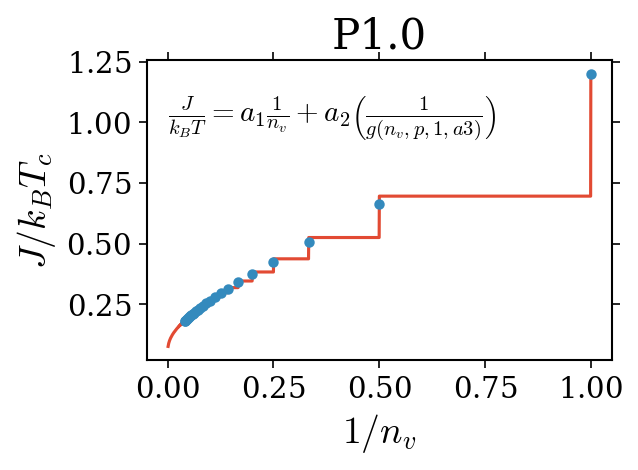

---------------------------------------------
a1: 0.47518175462754286
a2: 2.511984411078319
---------------------------------------------
min:0.07663296206003939 at 0.001


      fun: 0.006000964960705324
 hess_inv: array([[ 0.45792407, -2.47524929],
       [-2.47524929, 14.25083551]])
      jac: array([-1.59099000e-06, -3.75090167e-07])
  message: 'Optimization terminated successfully.'
     nfev: 68
      nit: 13
     njev: 17
   status: 0
  success: True
        x: array([0.4701204 , 2.33379914])
Best fit parameters: [0.4701204  2.33379914]


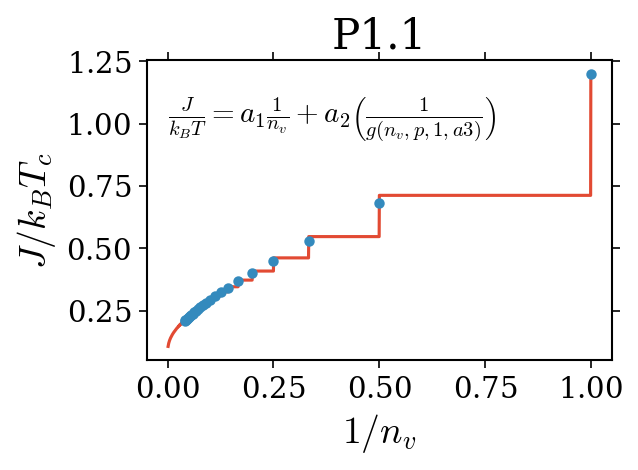

---------------------------------------------
a1: 0.47012039922038096
a2: 2.333799142255422
---------------------------------------------
min:0.10712602338633861 at 0.001


      fun: 0.005014322337200712
 hess_inv: array([[ 0.40554304, -1.95697888],
       [-1.95697888, 10.04129582]])
      jac: array([-1.59727642e-06, -3.12807970e-07])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 13
     njev: 15
   status: 0
  success: True
        x: array([0.46436252, 2.19746957])
Best fit parameters: [0.46436252 2.19746957]


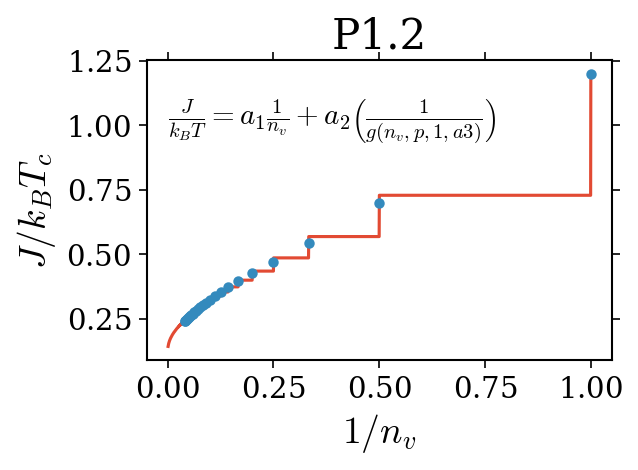

---------------------------------------------
a1: 0.4643625179690855
a2: 2.1974695722445867
---------------------------------------------
min:0.1438671625234987 at 0.001


      fun: 0.005264717645899391
 hess_inv: array([[ 0.37558862, -1.62495301],
       [-1.62495301,  7.46092559]])
      jac: array([-2.69908924e-07, -6.71134330e-08])
  message: 'Optimization terminated successfully.'
     nfev: 56
      nit: 12
     njev: 14
   status: 0
  success: True
        x: array([0.46018917, 2.08365165])
Best fit parameters: [0.46018917 2.08365165]


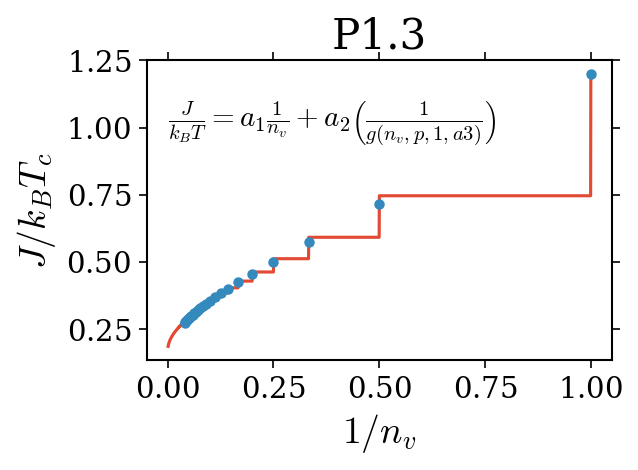

---------------------------------------------
a1: 0.4601891674204486
a2: 2.083651647763118
---------------------------------------------
min:0.18653702338478373 at 0.001


      fun: 0.004740097224298911
 hess_inv: array([[ 0.35864026, -1.40486677],
       [-1.40486677,  5.81310187]])
      jac: array([-2.93366611e-08, -2.32248567e-08])
  message: 'Optimization terminated successfully.'
     nfev: 56
      nit: 12
     njev: 14
   status: 0
  success: True
        x: array([0.4566056 , 1.98846743])
Best fit parameters: [0.4566056  1.98846743]


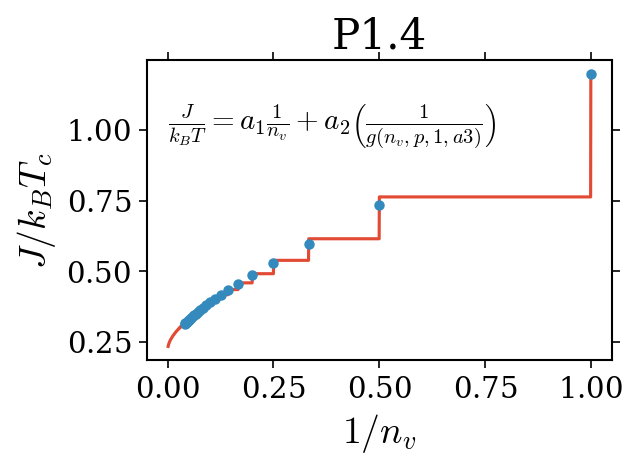

---------------------------------------------
a1: 0.45660560263617794
a2: 1.9884674312480468
---------------------------------------------
min:0.23366276580386966 at 0.001


      fun: 0.004246379933681022
 hess_inv: array([[ 0.35710079, -1.26996486],
       [-1.26996486,  4.74175324]])
      jac: array([-2.70991586e-06, -7.44650606e-07])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 12
     njev: 15
   status: 0
  success: True
        x: array([0.45404458, 1.90584124])
Best fit parameters: [0.45404458 1.90584124]


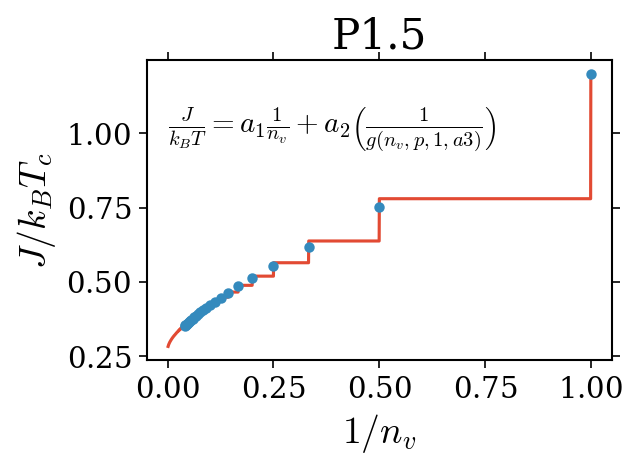

---------------------------------------------
a1: 0.45404457748412697
a2: 1.9058412358678534
---------------------------------------------
min:0.2838458016130487 at 0.001


      fun: 0.0037708553803892115
 hess_inv: array([[ 0.36362901, -1.18372815],
       [-1.18372815,  4.01784655]])
      jac: array([-4.75018169e-06, -1.63182267e-06])
  message: 'Optimization terminated successfully.'
     nfev: 64
      nit: 14
     njev: 16
   status: 0
  success: True
        x: array([0.4524345 , 1.83406076])
Best fit parameters: [0.4524345  1.83406076]


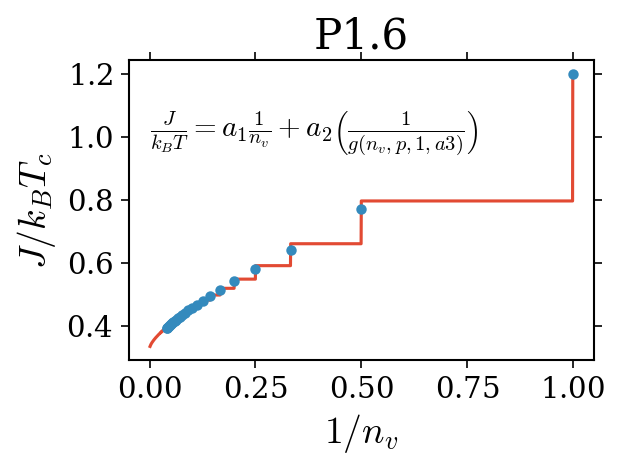

---------------------------------------------
a1: 0.45243450016223213
a2: 1.8340607633175614
---------------------------------------------
min:0.3356955869382427 at 0.001


      fun: 0.00334092948718801
 hess_inv: array([[ 0.40138224, -1.17999826],
       [-1.17999826,  3.59309868]])
      jac: array([1.11002009e-06, 3.04833520e-07])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 14
     njev: 18
   status: 0
  success: True
        x: array([0.45256778, 1.76820379])
Best fit parameters: [0.45256778 1.76820379]


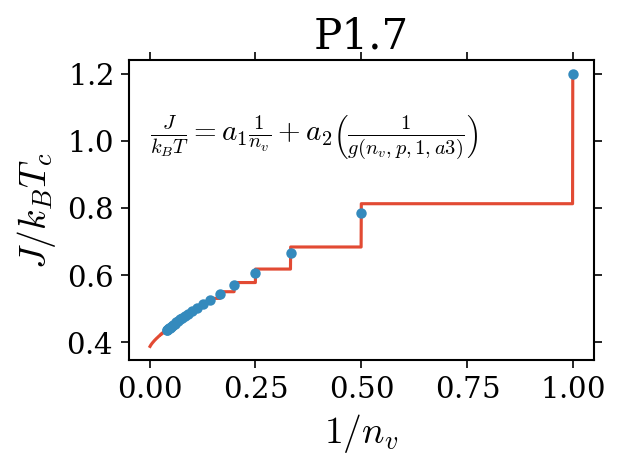

---------------------------------------------
a1: 0.4525677793367452
a2: 1.7682037906444208
---------------------------------------------
min:0.388131620858035 at 0.001


      fun: 0.0029365179196803705
 hess_inv: array([[ 0.42557203, -1.14358314],
       [-1.14358314,  3.1631353 ]])
      jac: array([7.80532719e-06, 2.38112989e-06])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 14
     njev: 18
   status: 0
  success: True
        x: array([0.45396441, 1.70875025])
Best fit parameters: [0.45396441 1.70875025]


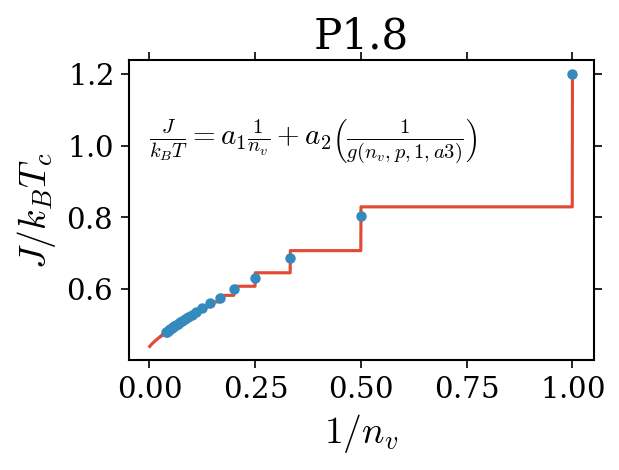

---------------------------------------------
a1: 0.4539644082389202
a2: 1.7087502527921263
---------------------------------------------
min:0.4400275556761745 at 0.001


      fun: 0.002657484630435979
 hess_inv: array([[ 0.48990302, -1.19912117],
       [-1.19912117,  3.00313481]])
      jac: array([ 5.17087756e-07, -5.76363527e-06])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 15
     njev: 21
   status: 0
  success: True
        x: array([0.45633808, 1.65551973])
Best fit parameters: [0.45633808 1.65551973]


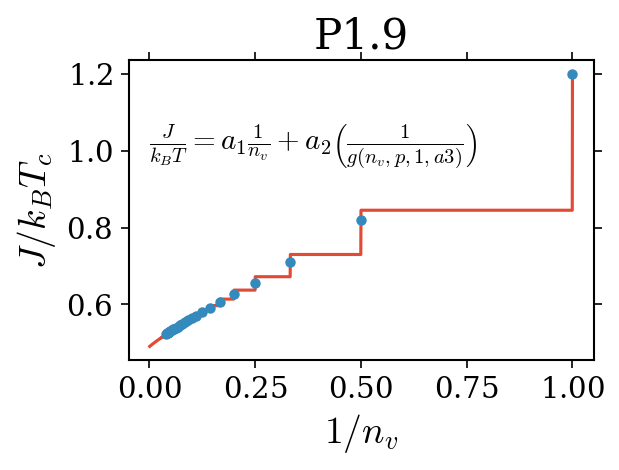

---------------------------------------------
a1: 0.45633808053488134
a2: 1.6555197305249343
---------------------------------------------
min:0.49061822213455897 at 0.001


      fun: 0.0027553247974962214
 hess_inv: array([[ 0.55542516, -1.23095711],
       [-1.23095711,  2.77865296]])
      jac: array([1.51226413e-06, 5.83968358e-07])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 16
     njev: 21
   status: 0
  success: True
        x: array([0.45999661, 1.60632326])
Best fit parameters: [0.45999661 1.60632326]


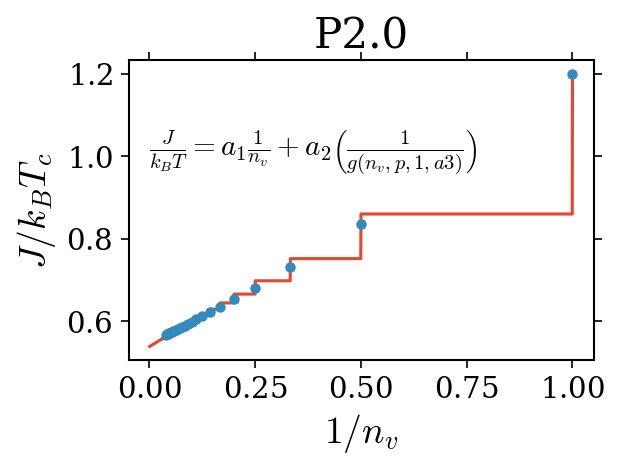

---------------------------------------------
a1: 0.45999660919695134
a2: 1.6063232648591128
---------------------------------------------
min:0.539265244065387 at 0.001




In [14]:
epsilon = 0.0001
COLUMNS = ["P1.0","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
path_save_graph = Path("../../graphs/").resolve()
file_name_base = 'inv_Tc_vs_inv_nv_extrapol_linear_and_zeta_funct_2_parms'
for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    file_graph = file_name_base + '_{}.png'.format(COLUMN)
    # Get the data in arrays
    df_part = df_all_tc[["1/nv",COLUMN]]
    df_part = df_part.dropna()
    x_data = df_part['1/nv'].values
    y_data = df_part[COLUMN].values
    # add value at nv=1
    x_data = np.concatenate([x_data,[1]])
    y_data = np.concatenate([y_data,[1.19968]])
#     if COLUMN == 'P1.0':
#         #add value at nv=infty
#         x_data = np.insert(x_data,0,0)
#         y_data = np.insert(y_data,0,0)
        
    # fit 
    best_fit_result = minimize(residuals_func_sum_sqr, x0=(1, 1))
    print(best_fit_result)
    best_fit_coefs = best_fit_result.x
    print("Best fit parameters:", best_fit_coefs)

    (a1,a2) = best_fit_coefs 
    df_params[COLUMN] = [a1,a2]
    extrapol_funct = get_extrapol_function(model_function, best_fit_coefs)
    
    # define the point for graph
    x_extrapol = np.linspace(0.001, 1, 2048)
    y_extrapol = []
    for x_ext in x_extrapol:
        y_extrapol.append(extrapol_funct(x_ext))

    # Load the default style.
    style.use("default")
    rcParams["text.usetex"] = False

    fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
    grid_spec = GridSpec(3, 1)

    # Specific heat subplot.
    ax: Axes = fig1.add_subplot(grid_spec[0, 0])

    ax.plot(x_extrapol, y_extrapol, lw=1.5)
    ax.plot(x_data, y_data, marker="o", lw=0)

    ax.set_xlabel(r"$1/n_v$")
    ax.set_ylabel(r"$J/k_BT_c$")
    # add text
    ax.text(0, 1, r"$\frac{J}{k_BT} = a_1 \frac{1}{n_v} + a_2 \left(\frac{1}{g(n_v,p,1,a3)}\right)$")

    ax.set_title(COLUMN)
    pyplot.draw()
#     print('Save graph {}'.format(os.path.join(path_save_graph,file_graph)))
#     pyplot.savefig(os.path.join(path_save_graph,file_graph))
    pyplot.show()
    print("---------------------------------------------")
    print("a1: {}\na2: {}".format(a1,a2))
    print("---------------------------------------------")
    df_extrapol_val[COLUMN] = [extrapol_funct(0+epsilon),extrapol_funct(1)]  
    print("min:{} at {}".format(np.nanmin(y_extrapol),x_extrapol[np.nanargmin(y_extrapol)]))    
    print("\n")


In [9]:
dir(ax.text)

NameError: name 'ax' is not defined

In [81]:
df_extrapol_val["P2.0"]['infty']

0.5359269860565828

In [17]:
from scipy.special import zeta
COLUMNS = ["P1.0","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    df_extrapol_val[COLUMN]['infty'] = df_params[COLUMN]['a1']*(1/zeta(p,df_params[COLUMN]['a2']))

## Save params

In [15]:
file_name_base

'inv_Tc_vs_inv_nv_extrapol_linear_and_zeta_funct_2_parms'

In [18]:
# Define tha path and name for the csv files
file_params = os.path.join(data_path,'Extrapolation',file_name_base+'_params_curves.csv')
file_extrapol_values = os.path.join(data_path,'Extrapolation',file_name_base+'_extrapol_values.csv')
print(df_params)
print("Exporting to csv files the params adjusted {}".format(file_params))
df_params.to_csv(file_params)
print(df_extrapol_val)
print("Exporting to csv files the extrapolation values adjusted {}".format(file_extrapol_values))
df_extrapol_val.to_csv(file_extrapol_values)

        P1.0      P1.1      P1.2      P1.3      P1.4      P1.5      P1.6  \
a1  0.475182  0.470120  0.464363  0.460189  0.456606  0.454045  0.452435   
a2  2.511984  2.333799  2.197470  2.083652  1.988467  1.905841  1.834061   

        P1.7      P1.8      P1.9      P2.0  
a1  0.452568  0.453964  0.456338  0.459997  
a2  1.768204  1.708750  1.655520  1.606323  
Exporting to csv files the params adjusted C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\data\Extrapolation\inv_Tc_vs_inv_nv_extrapol_linear_and_zeta_funct_2_parms_params_curves.csv
           P1.0      P1.1      P1.2      P1.3      P1.4      P1.5      P1.6  \
infty  0.000000  0.050016  0.103578  0.159431  0.216220  0.273057  0.329248   
1      1.193649  1.194205  1.194441  1.195113  1.195273  1.194617  1.194037   

           P1.7      P1.8      P1.9      P2.0  
infty  0.384394  0.437917  0.489453  0.538634  
1      1.192583  1.190812  1.189219  1.186917  
Exporting to csv files the extrapolation val

## Plot extrapol values

C:\Users\MHJGuillermo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


Save graph C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\graphs\Extrapolation\inv_Tc_vs_inv_nv_extrapol_linear_and_zeta_funct_2_parms_all_p.png


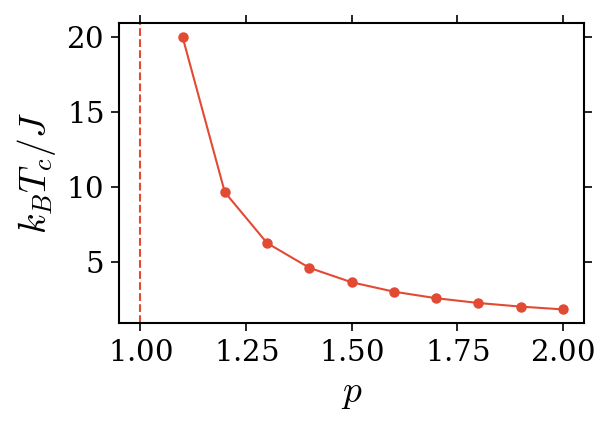

In [19]:
file_extrapol_graph = os.path.join(path_save_graph,'Extrapolation',file_name_base+'_all_p.png')
# data 
x_data = np.arange(1,2.1,0.1)
y_data = 1/df_extrapol_val.loc['infty'].values

# # data for squared 
# y_data = np.sqrt(y_data)

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(x_data, y_data, marker="o", lw=1)

ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$k_BT_c/J$")
ax.axvline(x=1,linestyle='--')

pyplot.draw()

print('Save graph {}'.format(file_extrapol_graph))
pyplot.savefig(file_extrapol_graph)

pyplot.show()